In [1]:
%matplotlib ipympl

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# some handy functions to use along widgets
from IPython.display import display, Markdown, clear_output
# widget packages
import ipywidgets as widgets

In [2]:
def read_pfgse_results(csvfile):
    results = {}
    df = pd.read_csv(csvfile)
    results['Time'] = df.Time.values
    results['Dsat'] = df.Dsat.values
    results['DmsdX'] = df.DmsdX.values
    results['DmsdY'] = df.DmsdY.values
    results['DmsdZ'] = df.DmsdZ.values
    results['Dmsd'] = df.Dmsd.values
    return results

def read_pfgse_params(paramsfile):
    params = {}
    with open(paramsfile) as f:
        lines = f.readlines()
        for line in lines:
            l = line.strip()
            if(len(l.split(': ')) == 2):
                params[l.split(': ')[0]] = l.split(': ')[1]
    return params

def read_pfgse_echoes(echoes_dir):
    echoes = [os.path.join(echoes_dir, ef) for ef in os.listdir(echoes_dir) if 'echoes_' in ef]
    e_order = []
    for i,e in enumerate(echoes):
        idx = int(e.split('_')[-1].split('.')[0])
        e_order.append(idx)
    echoes_files = [x for _,x in sorted(zip(e_order,echoes))]
    echoes = []
    for ef in echoes_files:
        ndict = {}
        df = pd.read_csv(ef)
        ndict['signal'] = df['NMR_signal(mean)'].values
        ndict['noise'] = df['NMR_signal(noise)'].values
        ndict['lhs'] = df['SAT_lhs(mean)'].values
        ndict['rhs'] = df['SAT_rhs'].values
        echoes.append(ndict)
    return echoes
    
    
def read_pfgse_gradients(grads_file):
    grads = {}
    df = pd.read_csv(grads_file)
    grads['Gx'] = df.Gx.values
    grads['Gy'] = df.Gy.values
    grads['Gz'] = df.Gz.values
    grads['Kx'] = df.Kx.values
    grads['Ky'] = df.Ky.values
    grads['Kz'] = df.Kz.values
    return grads    

def read_pfgse_from_dir(datadir):
    data = {}
    params = read_pfgse_params(os.path.join(datadir, 'PFGSE_parameters.txt'))
    results = read_pfgse_results(os.path.join(datadir, 'PFGSE_results.csv'))
    grads = read_pfgse_gradients(os.path.join(datadir, 'PFGSE_gradient.csv'))
    echoes = read_pfgse_echoes(os.path.join(datadir, 'timesamples'))
    
    for i,e in enumerate(echoes):
        e['time'] = results['Time'][i]
    
    data['params'] = params
    data['time'] = results['Time']
    data['Dsat'] = results['Dsat']
    data['Dmsd'] = results['Dmsd']
    data['DmsdX'] = results['DmsdX']
    data['DmsdY'] = results['DmsdY']
    data['DmsdZ'] = results['DmsdZ']
    data['Gx'] = grads['Gx']
    data['Gy'] = grads['Gy']
    data['Gz'] = grads['Gz']
    data['Kx'] = grads['Kx']
    data['Ky'] = grads['Ky']
    data['Kz'] = grads['Kz']
    data['echoes'] = echoes
    
    return data

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

In [10]:
db_dir = '/home/lablcc/Documents/matheus/cpp-rwnmr/db/NMR_PFG_BS_rho=27.0_w=1M_ws=1_n=0.002_shift=2_bulk=true'
data = read_pfgse_from_dir(os.path.join(db_dir,'NMR_pfgse'))

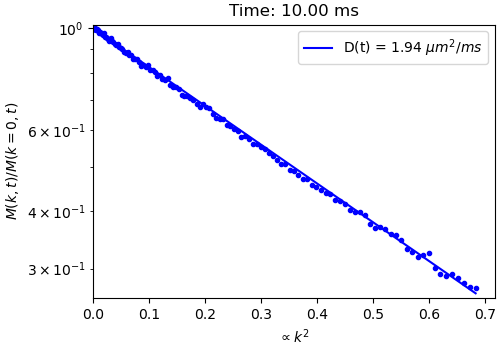

In [14]:
# If fig was created, replace it 
try:
   plt.close(fig2)
except:
    pass

output2 = widgets.Output()
 
with output2:
    fig2, axs2 = plt.subplots(1,1, figsize=(5.0,3.5), constrained_layout=True)

fig2.canvas.toolbar_position = 'bottom'    
start = 0
curr_idx = start
stride = 4
ntimes = data['time'].size
                   
xdata1 = -data['echoes'][curr_idx]['rhs'][::stride]
ydata1 = data['echoes'][curr_idx]['signal'][::stride]/data['echoes'][curr_idx]['signal'][0]
dline1, = axs2.semilogy(xdata1,ydata1,linestyle='none',marker='o',color='b',ms=3)
fit1, = axs2.plot([xdata1[0],xdata1[-1]],[1,np.exp(-data['Dsat'][curr_idx]*xdata1[-1])],
                     color='b',label=f"D(t) = {data['Dsat'][curr_idx]:.2f} $\mu m^{2}/ms$")

# axs2[0].set_xlabel(r'$-k^{2}(t-\delta/3)$')
axs2.set_xlabel(r'$\propto k^{2}$')
axs2.set_ylabel(r'$M(k,t)/M(k=0,t)$')
axs2.set_xlim([0,1.05*xdata1[-1]])
axs2.set_ylim([0.95*ydata1[-1],1.02*ydata1[0]])
axs2.set_yscale('log')
axs2.set_title(f"Time: {data['time'][curr_idx]:.2f} ms")
axs2.legend(loc='best')


# create some control elements
slider2 = widgets.IntSlider(
    value=0,
    min=0, max=ntimes-1-start, step=1,
    description='$t$',
    continuous_update=False
)
 
# callback function
def update_time(change):
    curr_idx = start + change.new
    xdata1 = -data['echoes'][curr_idx]['rhs'][::stride]
    ydata1 = data['echoes'][curr_idx]['signal'][::stride]/data['echoes'][curr_idx]['signal'][0]
    xlims = [0.0, 1.05*xdata1[-1]]
    ylims = [0.95*np.abs(ydata1[-1]),1.02]
    
    dline1.set_xdata(xdata1)
    dline1.set_ydata(ydata1)
    fit1.set_xdata([xdata1[0],xdata1[-1]])
    fit1.set_ydata([1,np.exp(-data['Dsat'][curr_idx]*xdata1[-1])])
    fit1.set_label(f"D(t) = {data['Dsat'][curr_idx]:.2f} $\mu m^{2}/ms$")
    axs2.set_title(f"Time: {data['time'][curr_idx]:.2f} ms")
    
    axs2.set_xlim(xlims)
    axs2.set_ylim(ylims)
    axs2.legend()
#     fig2.canvas.draw()


# connect callbacks and traits
slider2.observe(update_time, 'value')    
grapher2 = widgets.VBox([slider2, output2])
display(grapher2)